In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from typing import List, Dict, Tuple
import random
import re
import nltk
from nltk.corpus import brown
from nltk.util import ngrams, bigrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import ConditionalFreqDist, FreqDist
from nltk.corpus import stopwords
import math

In [ ]:
# Загружаем необходимые ресурсы NLTK
nltk.download('punkt')
nltk.download('brown')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# 1. Корпусы текстов. Закон Ципфа и стоп-слова в тексте

=== Задание 1: Анализ закона Ципфа и стоп-слов ===


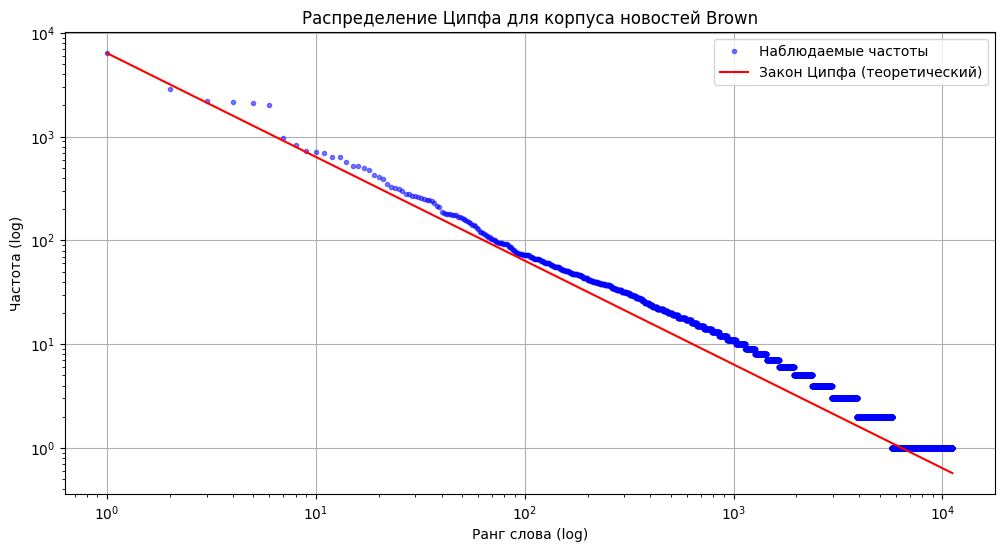


Топ-15 самых частотных слов:
1. the: 6386 раз (стоп-слово)
2. of: 2861 раз (стоп-слово)
3. and: 2186 раз (стоп-слово)
4. to: 2144 раз (стоп-слово)
5. a: 2130 раз (стоп-слово)
6. in: 2020 раз (стоп-слово)
7. for: 969 раз (стоп-слово)
8. that: 829 раз (стоп-слово)
9. is: 733 раз (стоп-слово)
10. was: 717 раз (стоп-слово)
11. on: 691 раз (стоп-слово)
12. he: 642 раз (стоп-слово)
13. at: 636 раз (стоп-слово)
14. with: 567 раз (стоп-слово)
15. be: 526 раз (стоп-слово)


In [ ]:
class CorpusAnalyzer:
    def __init__(self, category='news'):
        """
        Задание 1.1: Найдите корпус текстов и загрузите его
        В данном случае используется корпус Brown из NLTK, категория 'news'
        """
        self.sentences = brown.sents(categories=category)

        """
        Задание 1.2: Составьте список всех слов в корпусе, посчитайте частоту каждого слова
        """
        self.words = [word.lower() for sent in self.sentences for word in sent if word.isalpha()]
        self.word_freq = Counter(self.words)
        self.vocab_size = len(set(self.words))

        # Получаем стандартный список стоп-слов для сравнения
        self.standard_stopwords = set(stopwords.words('english'))

    def analyze_zipf_law(self):
        """
        Задание 1.3: Постройте график зависимости ранга слова от его частоты
        Задание 1.4: Определите 10-15 самых частотных слов и сравните со стоп-словами
        """
        # Сортировка слов по частоте
        sorted_freq = sorted(self.word_freq.items(), key=lambda x: x[1], reverse=True)
        ranks = range(1, len(sorted_freq) + 1)
        frequencies = [freq for word, freq in sorted_freq]

        # Построение графика закона Ципфа
        plt.figure(figsize=(12, 6))
        plt.loglog(ranks, frequencies, 'b.', alpha=0.5, label='Наблюдаемые частоты')

        # Теоретическая кривая Ципфа для сравнения
        c = frequencies[0]
        zipf_law = [c/r for r in ranks]
        plt.loglog(ranks, zipf_law, 'r-', label='Закон Ципфа (теоретический)')

        plt.xlabel('Ранг слова (log)')
        plt.ylabel('Частота (log)')
        plt.title('Распределение Ципфа для корпуса новостей Brown')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Анализ стоп-слов
        top_words = [word for word, freq in sorted_freq[:15]]
        print("\nТоп-15 самых частотных слов:")
        for i, (word, freq) in enumerate(sorted_freq[:15], 1):
            is_stopword = word in self.standard_stopwords
            print(f"{i}. {word}: {freq} раз ({'стоп-слово' if is_stopword else 'не стоп-слово'})")

        return

# Создаем анализатор и выполняем все задания
analyzer = CorpusAnalyzer(category='news')

print("=== Задание 1: Анализ закона Ципфа и стоп-слов ===")
analyzer.analyze_zipf_law()


# 2. Языковые модели, n-граммы, вероятностная модель с допущением Маркова

In [ ]:
class NgramModel:
    def __init__(self):
        self.bigrams = defaultdict(Counter)
        self.trigrams = defaultdict(lambda: defaultdict(Counter))
        self.word_count = Counter()

    def preprocess_sentences(self, sentences: List[List[str]]) -> List[List[str]]:
        """2.1 Предварительная обработка предложений."""
        # Приведение к нижнему регистру и удаление специальных символов
        processed = []
        for sentence in sentences:
            clean_sent = [re.sub(r'[^\w\s-]', '', word.lower())
                         for word in sentence]
            # Удаление пустых строк после очистки
            clean_sent = [word for word in clean_sent if word]
            if clean_sent:  # Добавляем только непустые предложения
                processed.append(clean_sent)
        return processed

    def train(self, sentences: List[List[str]]):
        """2.2 Обучает модель на предложениях из корпуса."""
        processed_sentences = self.preprocess_sentences(sentences)

        for sentence in processed_sentences:
            words = ['<START>'] + sentence + ['<END>']

            # Подсчет отдельных слов
            self.word_count.update(words)

            # Построение биграмм
            for i in range(len(words)-1):
                self.bigrams[words[i]][words[i+1]] += 1

            # Построение триграмм
            for i in range(len(words)-2):
                self.trigrams[words[i]][words[i+1]][words[i+2]] += 1

    def calculate_bigram_probability(self, word1: str, word2: str) -> float:
        """Вычисляет вероятность биграммы."""
        if word1 not in self.bigrams or word2 not in self.bigrams[word1]:
            return 0.0
        return self.bigrams[word1][word2] / sum(self.bigrams[word1].values())

    def calculate_trigram_probability(self, word1: str, word2: str, word3: str) -> float:
        """Вычисляет вероятность триграммы."""
        if word1 not in self.trigrams or word2 not in self.trigrams[word1] or word3 not in self.trigrams[word1][word2]:
            return 0.0
        return self.trigrams[word1][word2][word3] / sum(self.trigrams[word1][word2].values())

    def generate_sentence(self, model_type: str = 'bigram', max_length: int = 15) -> str:
        """2.3 Генерирует предложение используя биграммную или триграммную модель."""
        if model_type not in ['bigram', 'trigram']:
            raise ValueError("model_type должен быть 'bigram' или 'trigram'")

        sentence = ['<START>']

        while len(sentence) < max_length:
            if model_type == 'bigram':
                curr_word = sentence[-1]
                if curr_word not in self.bigrams or curr_word == '<END>':
                    break

                candidates = list(self.bigrams[curr_word].keys())
                weights = list(self.bigrams[curr_word].values())
                next_word = random.choices(candidates, weights=weights)[0]

            else:  # trigram
                if len(sentence) < 2:
                    curr_word = sentence[-1]
                    candidates = list(self.bigrams[curr_word].keys())
                    weights = list(self.bigrams[curr_word].values())
                    next_word = random.choices(candidates, weights=weights)[0]
                else:
                    w1, w2 = sentence[-2], sentence[-1]
                    if w1 not in self.trigrams or w2 not in self.trigrams[w1]:
                        break

                    candidates = list(self.trigrams[w1][w2].keys())
                    weights = list(self.trigrams[w1][w2].values())
                    next_word = random.choices(candidates, weights=weights)[0]

            sentence.append(next_word)
            if next_word == '<END>':
                break

        return ' '.join([word for word in sentence if word not in ['<START>', '<END>']])

    def get_bigram_probabilities(self, word: str, top_n: int = 5) -> List[Tuple[str, float]]:
        """Возвращает top_n наиболее вероятных следующих слов для данного слова (биграммы)."""
        if word not in self.bigrams:
            return []

        total_count = sum(self.bigrams[word].values())
        probs = [(next_word, count/total_count)
                 for next_word, count in self.bigrams[word].items()]
        return sorted(probs, key=lambda x: x[1], reverse=True)[:top_n]

    def get_trigram_probabilities(self, word1: str, word2: str, top_n: int = 5) -> List[Tuple[str, float]]:
        """Возвращает top_n наиболее вероятных следующих слов для пары слов (триграммы)."""
        if word1 not in self.trigrams or word2 not in self.trigrams[word1]:
            return []

        total_count = sum(self.trigrams[word1][word2].values())
        probs = [(next_word, count/total_count)
                 for next_word, count in self.trigrams[word1][word2].items()]
        return sorted(probs, key=lambda x: x[1], reverse=True)[:top_n]

    def get_most_common_contexts(self, top_n: int = 5) -> List[Tuple[str, str]]:
        """Возвращает top_n наиболее частых пар слов в корпусе."""
        context_counts = Counter()
        for word1 in self.trigrams:
            for word2 in self.trigrams[word1]:
                context_counts[(word1, word2)] = sum(self.trigrams[word1][word2].values())
        return context_counts.most_common(top_n)

# Получаем предложения из категории 'news' корпуса Brown
news_sentences = brown.sents(categories='news')

# Создание и обучение модели
model = NgramModel()
model.train(news_sentences)

# Анализ статистики корпуса
print(f"Статистика корпуса:")
print(f"Количество предложений: {len(news_sentences)}")
print(f"Уникальных слов: {len(model.word_count)}")
print(f"Количество уникальных биграмм: {sum(len(bigrams) for bigrams in model.bigrams.values())}")
print(f"Количество уникальных триграмм: {sum(sum(len(trigrams) for trigrams in word1_trigrams.values()) for word1_trigrams in model.trigrams.values())}")

# Анализ наиболее частых контекстов (пар слов)
print("\nНаиболее частые контексты (пары слов):")
common_contexts = model.get_most_common_contexts(5)
for (word1, word2), count in common_contexts:
    print(f"\nКонтекст: '{word1} {word2}' (встречается {count} раз)")
    print("Наиболее вероятные следующие слова (триграммы):")
    trigram_probs = model.get_trigram_probabilities(word1, word2)
    for next_word, prob in trigram_probs:
        print(f"  P({next_word}|{word1},{word2}) = {prob:.4f}")

# Вывод некоторых частых биграмм
print("\nНаиболее частые биграммы:")
for word in list(model.bigrams.keys())[:5]:
    most_common = model.bigrams[word].most_common(2)
    for next_word, count in most_common:
        prob = model.calculate_bigram_probability(word, next_word)
        print(f"P({next_word}|{word}) = {prob:.4f} (count: {count})")

# Генерация предложений
print("\nГенерация предложений (биграммная модель):")
for _ in range(3):
    print(model.generate_sentence('bigram'))

print("\nГенерация предложений (триграммная модель):")
for _ in range(3):
    print(model.generate_sentence('trigram'))

Статистика корпуса:
Количество предложений: 4623
Уникальных слов: 12818
Количество уникальных биграмм: 59873
Количество уникальных триграмм: 81795

Наиболее частые контексты (пары слов):

Контекст: 'of the' (встречается 849 раз)
Наиболее вероятные следующие слова (триграммы):
  P(new|of,the) = 0.0165
  P(united|of,the) = 0.0118
  P(year|of,the) = 0.0118
  P(american|of,the) = 0.0094
  P(state|of,the) = 0.0094

Контекст: '<START> the' (встречается 764 раз)
Наиболее вероятные следующие слова (триграммы):
  P(president|<START>,the) = 0.0249
  P(new|<START>,the) = 0.0144
  P(first|<START>,the) = 0.0131
  P(jury|<START>,the) = 0.0118
  P(city|<START>,the) = 0.0092

Контекст: 'in the' (встречается 589 раз)
Наиболее вероятные следующие слова (триграммы):
  P(past|in,the) = 0.0238
  P(state|in,the) = 0.0204
  P(first|in,the) = 0.0170
  P(last|in,the) = 0.0153
  P(early|in,the) = 0.0153

Контекст: 'to the' (встречается 277 раз)
Наиболее вероятные следующие слова (триграммы):
  P(state|to,the) =

# 3. Перплексия. Перекрёстная энтропия языковой модели

In [ ]:
def prepare_corpus(category='news', remove_stopwords=False):
    """Подготовка корпуса текстов"""
    # Загружаем тексты из указанной категории
    sentences = brown.sents(categories=category)

    # Преобразуем в нижний регистр и добавляем маркеры начала/конца предложения
    processed_sents = []
    stop_words = set(stopwords.words('english')) if remove_stopwords else set()

    for sent in sentences:
        sent = ['<s>'] + [w.lower() for w in sent if w.lower() not in stop_words] + ['</s>']
        processed_sents.append(sent)

    return processed_sents

def prepare_test_text(text, remove_stopwords=False):
    """Подготовка тестового текста"""
    stop_words = set(stopwords.words('english')) if remove_stopwords else set()

    # Разбиваем текст на предложения и токенизируем
    sentences = nltk.sent_tokenize(text)
    processed_sents = []

    for sent in sentences:
        tokens = word_tokenize(sent)
        tokens = ['<s>'] + [w.lower() for w in tokens if w.lower() not in stop_words] + ['</s>']
        processed_sents.append(tokens)

    return processed_sents

def create_ngram_model(sentences, n=2):
    """Создание n-граммной модели"""
    # Создаем частотные распределения
    if n == 2:
        cfd = ConditionalFreqDist(
            (sent[i], sent[i+1])
            for sent in sentences
            for i in range(len(sent)-1)
        )
        vocabulary = set(word for sent in sentences for word in sent)
        return cfd, vocabulary

    elif n == 3:
        # Для триграмм используем вложенный defaultdict
        cfd = defaultdict(lambda: defaultdict(FreqDist))
        vocabulary = set()

        for sent in sentences:
            for w1, w2, w3 in ngrams(sent, 3):
                cfd[w1][w2][w3] += 1
                vocabulary.update([w1, w2, w3])

        return cfd, vocabulary

def calculate_perplexity(test_sentences, model, vocabulary, n=2, smoothing=1):
    """Вычисление перплексии"""
    log_prob_sum = 0
    total_words = 0
    V = len(vocabulary)

    if n == 2:
        cfd = model
        for sent in test_sentences:
            for i in range(len(sent)-1):
                w1, w2 = sent[i], sent[i+1]
                count_w1 = sum(cfd[w1].values()) or 0
                count_bigram = cfd[w1][w2] if w1 in cfd else 0

                # Add-one smoothing
                prob = (count_bigram + smoothing) / (count_w1 + smoothing * V)
                log_prob_sum += math.log2(prob) if prob > 0 else 0
                total_words += 1

    elif n == 3:
        cfd = model
        for sent in test_sentences:
            for i in range(len(sent)-2):
                w1, w2, w3 = sent[i], sent[i+1], sent[i+2]
                count_w1w2 = sum(cfd[w1][w2].values()) if w1 in cfd and w2 in cfd[w1] else 0
                count_trigram = cfd[w1][w2][w3] if w1 in cfd and w2 in cfd[w1] else 0

                # Add-one smoothing
                prob = (count_trigram + smoothing) / (count_w1w2 + smoothing * V)
                log_prob_sum += math.log2(prob) if prob > 0 else 0
                total_words += 1

    perplexity = 2 ** (-log_prob_sum / total_words) if total_words > 0 else float('inf')
    return perplexity

def run_experiments():
    """Проведение экспериментов"""

    # 3.1. Построение модели на корпусе новостей
    print("1. Построение языковой модели")
    train_sents = prepare_corpus(category='news')
    model, vocab = create_ngram_model(train_sents, n=2)
    print(f"Размер обучающего корпуса: {len(train_sents)} предложений")
    print(f"Размер словаря: {len(vocab)} слов")

    # 3.2. Тестирование на новом тексте
    print("\n2. Тестирование на новом тексте")
    test_text = """
    The economy has shown significant growth in the last quarter,
    according to recent reports. Analysts suggest this trend might
    continue into the next year, despite global challenges.
    The Federal Reserve is closely monitoring these developments.
    """
    test_sents = prepare_test_text(test_text)

    print("Тестовый текст:")
    print(test_text)
    perplexity = calculate_perplexity(test_sents, model, vocab, n=2)
    print(f"\nПерплексия на тестовом тексте (биграммы): {perplexity:.2f}")

    # 3.3. Эксперименты
    print("\n3. Дополнительные эксперименты")

    # 3.3.1 Без стоп-слов
    test_sents_no_stops = prepare_test_text(test_text, remove_stopwords=True)
    train_sents_no_stops = prepare_corpus(category='news', remove_stopwords=True)
    model_no_stops, vocab_no_stops = create_ngram_model(train_sents_no_stops, n=2)
    perplexity_no_stops = calculate_perplexity(test_sents_no_stops, model_no_stops, vocab_no_stops, n=2)
    print(f"Перплексия без стоп-слов: {perplexity_no_stops:.2f}")

    # 3.3.2 Уменьшенный корпус
    train_sents_small = train_sents[:len(train_sents)//2]
    model_small, vocab_small = create_ngram_model(train_sents_small, n=2)
    perplexity_small = calculate_perplexity(test_sents, model_small, vocab_small, n=2)
    print(f"Перплексия на уменьшенном корпусе: {perplexity_small:.2f}")

if __name__ == "__main__":
    run_experiments()

1. Построение языковой модели
Размер обучающего корпуса: 4623 предложений
Размер словаря: 13114 слов

2. Тестирование на новом тексте
Тестовый текст:

    The economy has shown significant growth in the last quarter, 
    according to recent reports. Analysts suggest this trend might 
    continue into the next year, despite global challenges. 
    The Federal Reserve is closely monitoring these developments.
    

Перплексия на тестовом тексте (биграммы): 2393.33

3. Дополнительные эксперименты
Перплексия без стоп-слов: 4251.58
Перплексия на уменьшенном корпусе: 2089.19


# 4. Методы сглаживания в вероятностных языковых моделях

In [ ]:
# Загружаем корпус новостей Brown
news_text = brown.words(categories='news')
# Приводим все слова к нижнему регистру
news_text = [word.lower() for word in news_text]

# Создаем списки униграмм и биграмм
unigrams = news_text
bigram_pairs = list(bigrams(news_text))

# Подсчет частот
unigram_freq = defaultdict(int)
bigram_freq = defaultdict(int)

for word in unigrams:
    unigram_freq[word] += 1

for w1, w2 in bigram_pairs:
    bigram_freq[(w1, w2)] += 1

# Размер словаря (V)
vocabulary_size = len(set(unigrams))

# Функция для вычисления вероятности биграммы без сглаживания
def bigram_probability(bigram):
    w1, w2 = bigram
    if w1 not in unigram_freq or bigram not in bigram_freq:
        return 0.0
    return bigram_freq[bigram] / unigram_freq[w1]

# Функция для вычисления вероятности биграммы со сглаживанием Лапласа
def laplace_smoothed_probability(bigram):
    w1, w2 = bigram
    numerator = bigram_freq[bigram] + 1
    denominator = unigram_freq[w1] + vocabulary_size
    return numerator / denominator

# Создадим несколько биграмм, которых нет в корпусе
test_bigrams = [
    ('computer', 'science'),
    ('artificial', 'intelligence'),
    ('neural', 'network'),
    ('machine', 'learning'),
    ('deep', 'learning'),
    ('data', 'analysis'),
    ('programming', 'language'),
    ('statistical', 'model')
]

# Сравним вероятности
print("\nСравнение вероятностей биграмм:")
print("\n{:<30} {:<20} {:<20}".format("Биграмма", "Без сглаживания", "Со сглаживанием"))
print("-" * 70)

for bigram in test_bigrams:
    prob_no_smooth = bigram_probability(bigram)
    prob_smoothed = laplace_smoothed_probability(bigram)

    print("{:<30} {:<20.10f} {:<20.10f}".format(
        f"'{bigram[0]} {bigram[1]}'",
        prob_no_smooth,
        prob_smoothed
    ))

# Статистика корпуса
print(f"\nРазмер словаря (V): {vocabulary_size}")
print(f"Всего униграмм: {len(unigrams)}")
print(f"Всего уникальных биграмм: {len(bigram_freq)}")


Сравнение вероятностей биграмм:

Биграмма                       Без сглаживания      Со сглаживанием     
----------------------------------------------------------------------
'computer science'             0.0000000000         0.0000762660        
'artificial intelligence'      0.0000000000         0.0000762544        
'neural network'               0.0000000000         0.0000762660        
'machine learning'             0.0000000000         0.0000762369        
'deep learning'                0.0000000000         0.0000762253        
'data analysis'                0.0000000000         0.0000762428        
'programming language'         0.0000000000         0.0000762660        
'statistical model'            0.0000000000         0.0000762602        

Размер словаря (V): 13112
Всего униграмм: 100554
Всего уникальных биграмм: 61145
